# Kendrick Lamar: Artist Evolution Analysis
**Exploring the musical progression of Kendrick Lamar over his discography.**  

In this project, we analyse key metrics such as energy, popularity, tempo, and song duration across Kendrick Lamar’s albums to uncover how his style and musical complexity have evolved over time.

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from spotify_auth import sp  # Our Spotify API authentication

# Set plot styles
sns.set(style="whitegrid")

## Artist Information
Let's start by retrieving basic information about Kendrick Lamar.

In [2]:
# Function to get artist info
def get_artist_info(artist_name):
    # Search for the artist
    result = sp.search(q=artist_name, type='artist', limit=1)
    artist = result['artists']['items'][0]
    
    # Display artist information
    print(f"Artist Name: {artist['name']}")
    print(f"Genres: {artist['genres']}")
    print(f"Followers: {artist['followers']['total']}")
    print(f"Popularity: {artist['popularity']}")
    
    return artist['id']  # Return artist ID for further use

# Retrieve Kendrick Lamar's artist ID
kendrick_id = get_artist_info("Kendrick Lamar")


Artist Name: Kendrick Lamar
Genres: ['conscious hip hop', 'hip hop', 'rap', 'west coast rap']
Followers: 34068852
Popularity: 92


The above output also confirms that the connection to the Spotify API works. We then move on to create data frames containing information about Kendrick's albums and tracks

## Album Data Extraction

In [3]:
# Function to retrieve albums by the artist
def get_albums(artist_id):
    albums = sp.artist_albums(artist_id, album_type='album', limit=50)
    album_info = []

    for album in albums['items']:
        album_info.append({
            "Album Name": album['name'],
            "Release Date": album['release_date'],
            "Total Tracks": album['total_tracks'],
            "Album ID": album['id']
        })

    # Convert album data to DataFrame for easier handling
    album_df = pd.DataFrame(album_info).drop_duplicates(subset="Album Name").reset_index(drop=True)
    return album_df

# Retrieve Kendrick's albums
kendrick_albums = get_albums(kendrick_id)
kendrick_albums

,Album Name,Release Date,Total Tracks,Album ID
0,Mr. Morale & The Big Steppers,2022-05-13,19,79ONNoS4M9tfIA1mYLBYVX
1,Black Panther The Album Music From And Inspire...,2018-02-09,14,3pLdWdkj83EYfDN6H2N8MR
2,DAMN. COLLECTORS EDITION.,2017-12-08,14,4alcGHjstaALJHHiljfy3H
3,DAMN.,2017-04-14,14,4eLPsYPBmXABThSJ821sqY
4,untitled unmastered.,2016-03-04,8,0kL3TYRsSXnu0iJvFO3rud
5,To Pimp A Butterfly,2015-03-16,16,7ycBtnsMtyVbbwTfJwRjSP
6,"good kid, m.A.A.d city (Deluxe)",2012-10-22,17,748dZDqSZy6aPXKcI9H80u
7,"good kid, m.A.A.d city",2012,14,0Oq3mWfexhsjUh0aNNBB5u
8,Section.80,2011-07-02,15,1bkN9nIkkCnXeG4yitVS1J
9,Overly Dedicated,2010-09-14,12,7MoLQ8vckhwBbQqEYQTYQC


From the `album_df` above, we can see that there are some deluxe versions of projects such as 'good kid, m.A.A.d city' and 'DAMN'. This is very common where artists release special editions. To keep the analysis clean and focused on the core albums, we’ll filter out any duplicates or collector editions

In [4]:
# Updated function to retrieve albums and filter out special editions
def get_albums(artist_id):
    albums = sp.artist_albums(artist_id, album_type='album', limit=50)
    album_info = []

    for album in albums['items']:
        album_name = album['name'].lower()  # Convert to lowercase for easier matching

        # Exclude collector's editions, deluxe editions, or duplicates
        if "collector" not in album_name and "deluxe" not in album_name:
            album_info.append({
                "Album Name": album['name'],
                "Release Date": album['release_date'],
                "Total Tracks": album['total_tracks'],
                "Album ID": album['id']
            })

          # Convert to DataFrame, drop duplicates, and sort by release date
    album_df = pd.DataFrame(album_info).drop_duplicates(subset="Album Name").sort_values(by="Release Date").reset_index(drop=True)
    return album_df

# Retrieve Kendrick's filtered albums
kendrick_albums_filtered = get_albums(kendrick_id)
kendrick_albums_filtered

,Album Name,Release Date,Total Tracks,Album ID
0,Overly Dedicated,2010-09-14,12,7MoLQ8vckhwBbQqEYQTYQC
1,Section.80,2011-07-02,15,1bkN9nIkkCnXeG4yitVS1J
2,"good kid, m.A.A.d city",2012,14,0Oq3mWfexhsjUh0aNNBB5u
3,To Pimp A Butterfly,2015-03-16,16,7ycBtnsMtyVbbwTfJwRjSP
4,untitled unmastered.,2016-03-04,8,0kL3TYRsSXnu0iJvFO3rud
5,DAMN.,2017-04-14,14,4eLPsYPBmXABThSJ821sqY
6,Black Panther The Album Music From And Inspire...,2018-02-09,14,3pLdWdkj83EYfDN6H2N8MR
7,Mr. Morale & The Big Steppers,2022-05-13,19,79ONNoS4M9tfIA1mYLBYVX


## Track Data Extraction

For each album in our filtered list, we’ll retrieve individual track details such as energy, tempo, danceability, popularity, and duration. This data will help us analyse musical characteristics across Kendrick’s albums.

In [5]:
# Function to get tracks and their features for each album
def get_tracks(album_df):
    track_info = []

    for idx, row in album_df.iterrows():
        album_id = row['Album ID']
        album_name = row['Album Name']
        release_date = row['Release Date']

        # Retrieve track data for the album
        tracks = sp.album_tracks(album_id)
        for track in tracks['items']:
            # Get audio features (like energy, tempo, etc.) for each track
            track_features = sp.audio_features(track['id'])[0]

            # Append relevant details to our track list
            track_info.append({
                "Album Name": album_name,
                "Release Date": release_date,
                "Track Name": track['name'],
                "Track ID": track['id'],
                "Duration (ms)": track_features['duration_ms'],
                "Popularity": sp.track(track['id'])['popularity'],
                "Energy": track_features['energy'],
                "Tempo": track_features['tempo'],
                "Danceability": track_features['danceability'],
                "Acousticness": track_features['acousticness'],
                "Liveness": track_features['liveness']
            })

    # Convert track data to DataFrame for analysis
    track_df = pd.DataFrame(track_info)
    return track_df

# Retrieve Kendrick's track data
kendrick_tracks = get_tracks(kendrick_albums_filtered)
kendrick_tracks.head()

,Album Name,Release Date,Track Name,Track ID,Duration (ms),Popularity,Energy,Tempo,Danceability,Acousticness,Liveness
0,Overly Dedicated,2010-09-14,Growing Apart (To Get Closer),2AyFYSaJjz9XMc0kMr1R3a,220995,48,0.533,106.835,0.586,0.368,0.175
1,Overly Dedicated,2010-09-14,Ignorance Is Bliss,53mCo1wDJ12iZNq9LgIeg2,210495,51,0.801,82.156,0.644,0.511,0.614
2,Overly Dedicated,2010-09-14,P&P 1.5,6TRVvpoVFwyYyIGTFh0Y7P,361942,51,0.692,146.453,0.550,0.299,0.198
3,Overly Dedicated,2010-09-14,Alien Girl (Today W/ Her),6ff9CLXYk39PKFYoYCYeog,239974,48,0.537,95.948,0.626,0.502,0.111
4,Overly Dedicated,2010-09-14,Opposites Attract (Tomorrow W/O Her),1S6NpdvFXqHZfPUUEOIjtG,271909,50,0.814,192.157,0.608,0.657,0.256


## Data Preparation and Cleaning

In this step, we’ll prepare the extracted track data for analysis. This involves inspecting the data for any inconsistencies, handling missing values, converting units where necessary, and organizing columns to ensure clarity.

In [6]:
# Display the first few rows to inspect the data
kendrick_tracks.head()

,Album Name,Release Date,Track Name,Track ID,Duration (ms),Popularity,Energy,Tempo,Danceability,Acousticness,Liveness
0,Overly Dedicated,2010-09-14,Growing Apart (To Get Closer),2AyFYSaJjz9XMc0kMr1R3a,220995,48,0.533,106.835,0.586,0.368,0.175
1,Overly Dedicated,2010-09-14,Ignorance Is Bliss,53mCo1wDJ12iZNq9LgIeg2,210495,51,0.801,82.156,0.644,0.511,0.614
2,Overly Dedicated,2010-09-14,P&P 1.5,6TRVvpoVFwyYyIGTFh0Y7P,361942,51,0.692,146.453,0.550,0.299,0.198
3,Overly Dedicated,2010-09-14,Alien Girl (Today W/ Her),6ff9CLXYk39PKFYoYCYeog,239974,48,0.537,95.948,0.626,0.502,0.111
4,Overly Dedicated,2010-09-14,Opposites Attract (Tomorrow W/O Her),1S6NpdvFXqHZfPUUEOIjtG,271909,50,0.814,192.157,0.608,0.657,0.256


In [7]:
# Check for any missing values
kendrick_tracks.isnull().sum()

Album Name       0
Release Date     0
Track Name       0
Track ID         0
Duration (ms)    0
Popularity       0
Energy           0
Tempo            0
Danceability     0
Acousticness     0
Liveness         0
dtype: int64

In [8]:
kendrick_tracks.dtypes

Album Name        object
Release Date      object
Track Name        object
Track ID          object
Duration (ms)      int64
Popularity         int64
Energy           float64
Tempo            float64
Danceability     float64
Acousticness     float64
Liveness         float64
dtype: object

In [9]:
# Convert duration from milliseconds to minutes
kendrick_tracks['Duration (min)'] = kendrick_tracks['Duration (ms)'] / 60000

In [10]:
# Drop the original 'Duration (ms)' column if it's no longer needed
kendrick_tracks = kendrick_tracks.drop(columns=['Track ID', 'Duration (ms)'])

In [11]:
#Final output upon a bit of data prep and cleaning
kendrick_tracks.head()

,Album Name,Release Date,Track Name,Popularity,Energy,Tempo,Danceability,Acousticness,Liveness,Duration (min)
0,Overly Dedicated,2010-09-14,Growing Apart (To Get Closer),48,0.533,106.835,0.586,0.368,0.175,3.683250
1,Overly Dedicated,2010-09-14,Ignorance Is Bliss,51,0.801,82.156,0.644,0.511,0.614,3.508250
2,Overly Dedicated,2010-09-14,P&P 1.5,51,0.692,146.453,0.550,0.299,0.198,6.032367
3,Overly Dedicated,2010-09-14,Alien Girl (Today W/ Her),48,0.537,95.948,0.626,0.502,0.111,3.999567
4,Overly Dedicated,2010-09-14,Opposites Attract (Tomorrow W/O Her),50,0.814,192.157,0.608,0.657,0.256,4.531817


### Album-Level Analysis  
To get an overview of Kendrick’s evolution, we start by calculating average values for key metrics (such as energy, tempo, popularity) across each album. This helps us see how his musical style changes from one album to the next.


In [12]:
# Group by album and calculate the average for each metric
album_summary = kendrick_tracks.groupby('Album Name').mean()[['Energy', 'Tempo', 'Popularity', 'Danceability', 'Acousticness', 'Liveness']]

# Sort by release date for better chronological order
album_summary = album_summary.reindex(kendrick_tracks['Album Name'].unique())

# Display the summary
album_summary

/var/folders/3f/30mhkddx04v1q2z6xcxb1bs00000gn/T/ipykernel_1914/2298115166.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  album_summary = kendrick_tracks.groupby('Album Name').mean()[['Energy', 'Tempo', 'Popularity', 'Danceability', 'Acousticness', 'Liveness']]


,Energy,Tempo,Popularity,Danceability,Acousticness,Liveness
Album Name,,,,,,
Overly Dedicated,0.720167,110.896917,47.833333,0.635750,0.299508,0.235975
Section.80,0.777267,124.596000,55.466667,0.567133,0.411780,0.327267
"good kid, m.A.A.d city",0.665429,113.409143,55.214286,0.587429,0.123420,0.332143
To Pimp A Butterfly,0.707625,103.444563,61.875000,0.590750,0.322889,0.318419
untitled unmastered.,0.489625,111.075750,55.250000,0.638625,0.442025,0.324975
DAMN.,0.584857,136.751857,70.571429,0.663000,0.175444,0.223071
Black Panther The Album Music From And Inspired By,0.619214,121.250500,55.500000,0.685643,0.184566,0.182729
Mr. Morale & The Big Steppers,0.577053,121.557789,63.842105,0.632737,0.481211,0.156121


### Album-Level Visualization  
To better interpret the data, we’ll visualise the average values for key metrics across each album. This helps reveal any clear stylistic shifts from one album to the next.


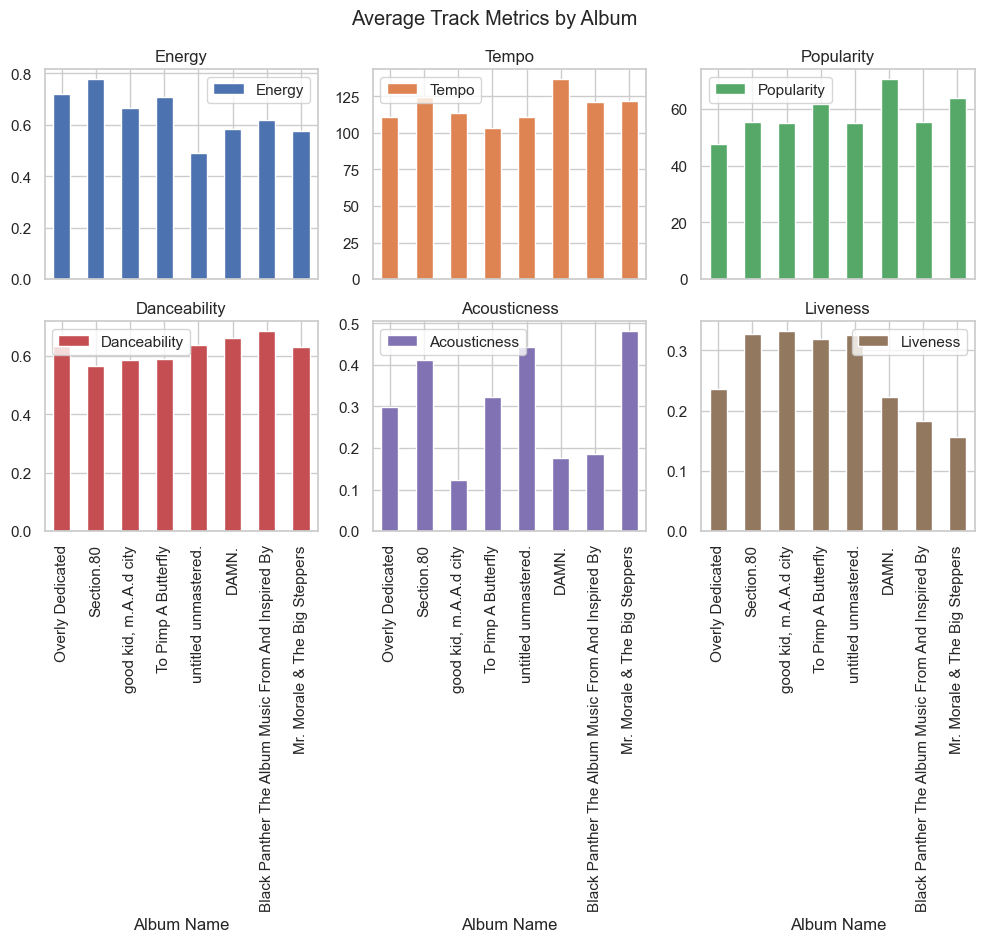

In [13]:
# Plot the average energy, tempo, and other features by album
album_summary.plot(kind='bar', figsize=(12, 6), subplots=True, layout=(2, 3), sharex=True)
plt.suptitle("Average Track Metrics by Album")
plt.show()


### Track-Level Analysis  
Next, we examine individual tracks within each album. By visualising metrics like energy or tempo for each track, we can identify standout tracks and within-album variations.

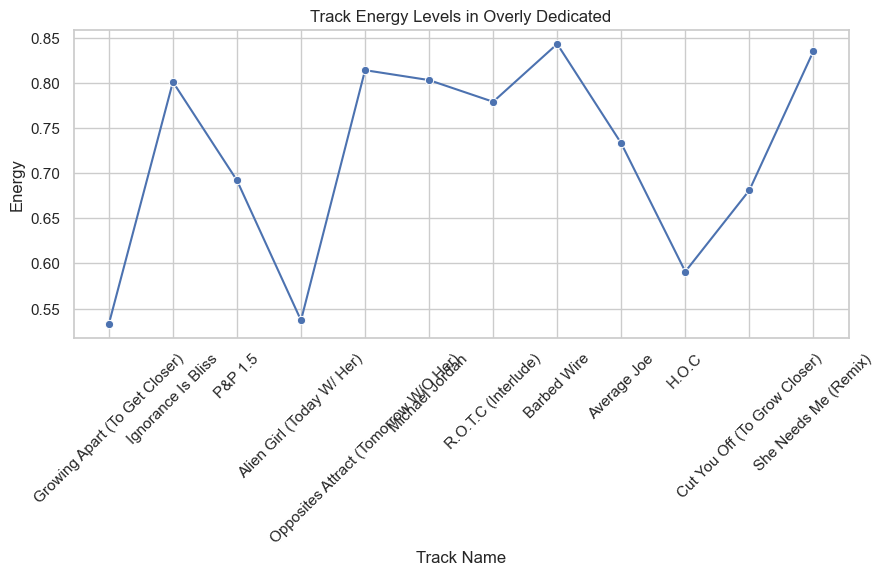

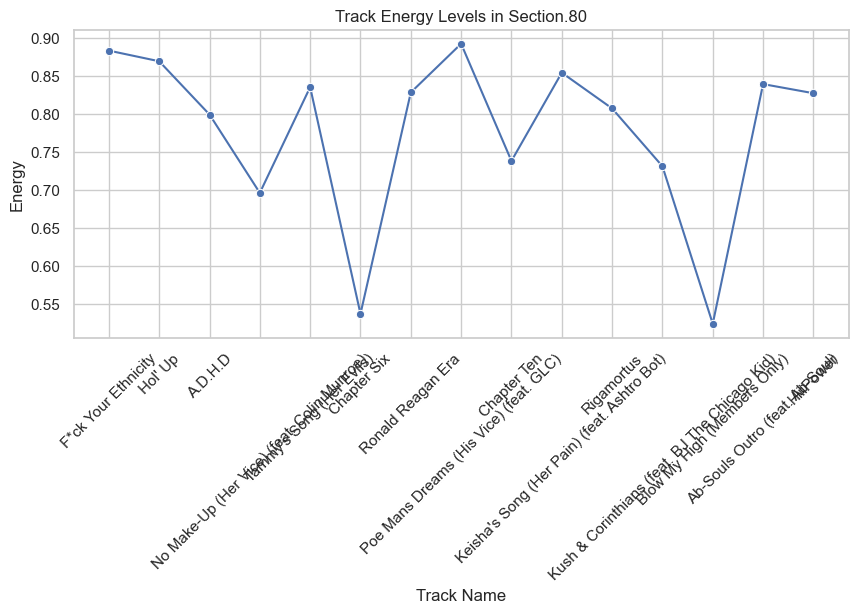

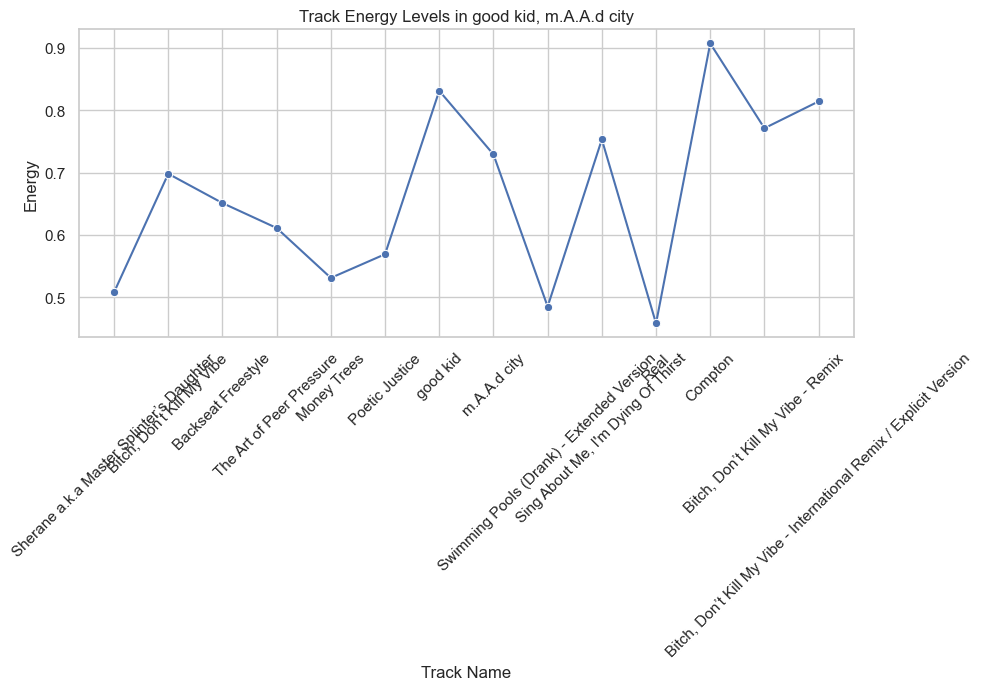

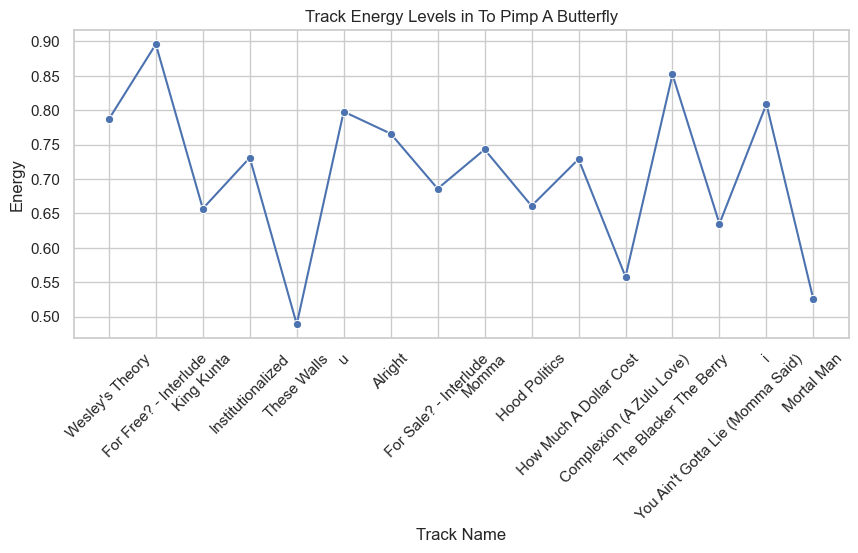

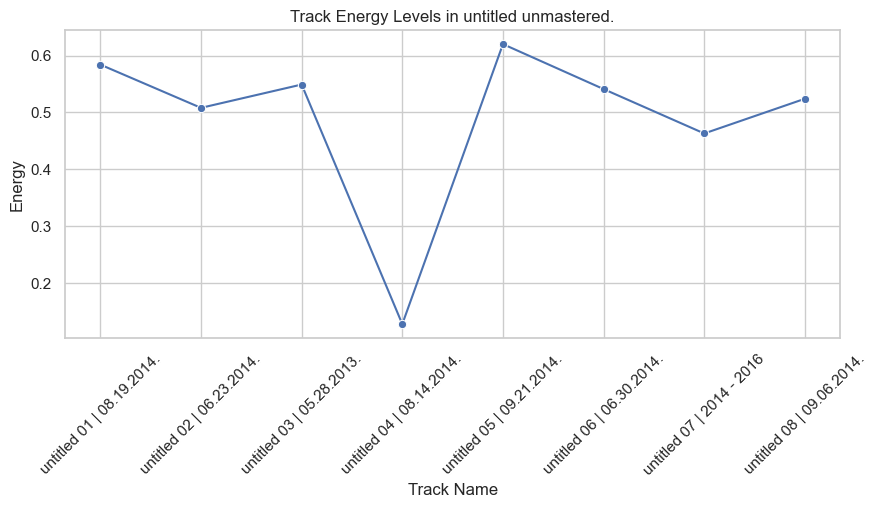

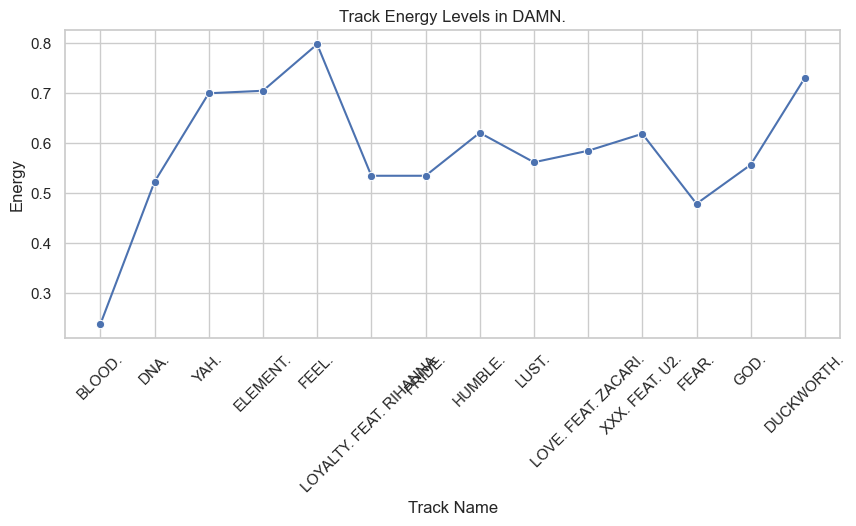

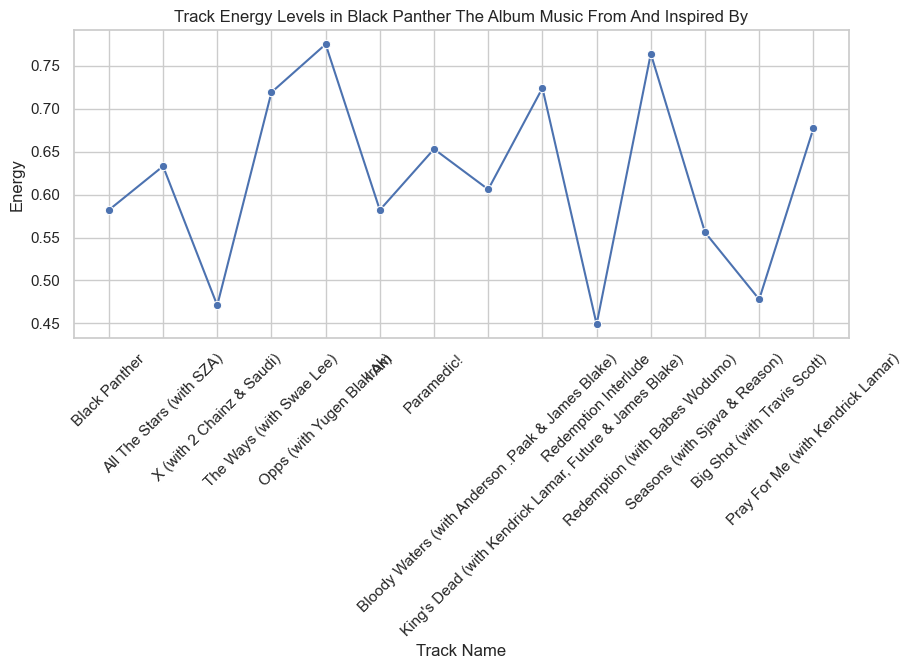

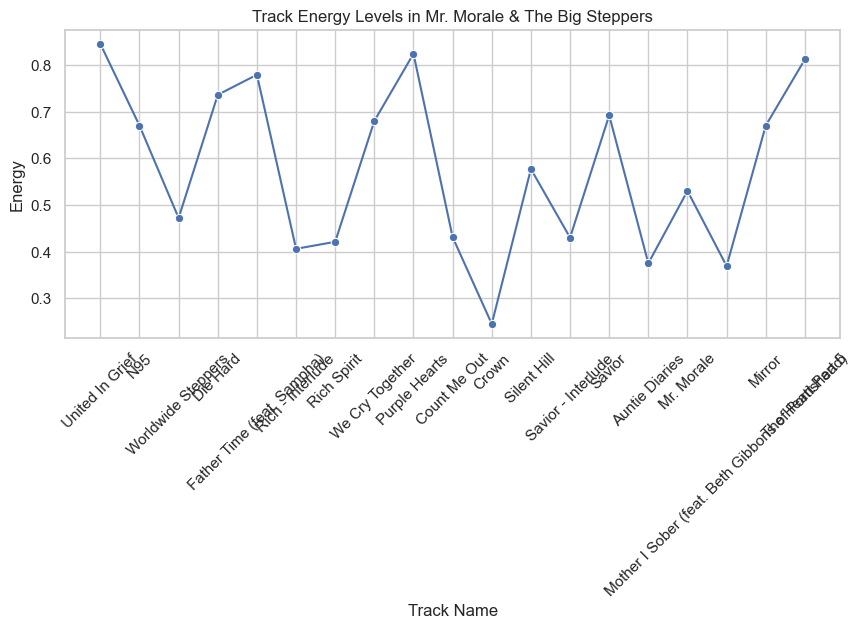

In [15]:
# Plot each album separately to avoid clutter
albums = kendrick_tracks['Album Name'].unique()

for album in albums:
    plt.figure(figsize=(10, 4))
    album_data = kendrick_tracks[kendrick_tracks['Album Name'] == album]
    sns.lineplot(data=album_data, x='Track Name', y='Energy', marker='o')
    plt.xticks(rotation=45)
    plt.title(f"Track Energy Levels in {album}")
    plt.show()

### Long-Term Trend Analysis  
Finally, let’s look at how Kendrick’s style has evolved over his career. We’ll plot key metrics over time to reveal any long-term trends.


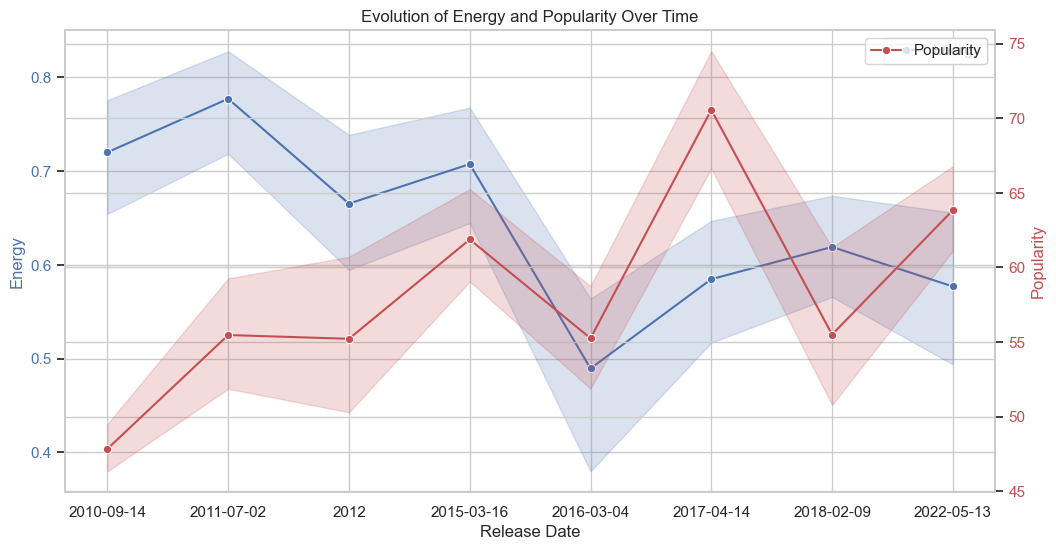

In [22]:
# Create a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Energy on the first y-axis
sns.lineplot(data=kendrick_tracks, x='Release Date', y='Energy', marker='o', label='Energy', ax=ax1, color='b')
ax1.set_ylabel('Energy', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for Popularity
ax2 = ax1.twinx()
sns.lineplot(data=kendrick_tracks, x='Release Date', y='Popularity', marker='o', label='Popularity', ax=ax2, color='r')
ax2.set_ylabel('Popularity', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and show plot
plt.title("Evolution of Energy and Popularity Over Time")
plt.show()

**Not sure how to fix the legend display - someone help!?**

### Kendrick Lamar’s Musical Evolution: Summary

**Overview**  
This project looked at Kendrick Lamar's albums over time, focusing on changes in energy, tempo, popularity, and other music features. By analysing each album and tracking his style over time, I aimed to see how Kendrick’s sound has developed.

**Album Insights**  
- Early albums like *Section.80* and *good kid, m.A.A.d city* show higher energy, fitting Kendrick’s intense and gritty style from that era.
- *To Pimp a Butterfly* has lower energy on average but higher danceability, which lines up with the jazz and funk influences on that album.

**Long-Term Trends**  
- **Energy**: There’s a general drop in energy over time, especially in recent albums. This might reflect Kendrick’s shift toward more reflective and experimental tracks.
- **Popularity**: Popularity peaked with *DAMN.*, which makes sense given its mainstream success, and it’s remained steady in later albums.

**Standout Tracks**  
- Songs like "HUMBLE." on *DAMN.* have notably high energy, which matches their hit status. On the flip side, tracks on *untitled unmastered.* are more experimental and break from the usual patterns, showing Kendrick’s versatility.

**Conclusion**  
Overall, Kendrick’s style has evolved from high-energy rap to a more varied and complex sound. This change is clear in the metrics and reflects his growth as an artist, balancing experimentation with his core style.
